# Sprint  深層学習スクラッチ　畳み込みニューラルネットワーク  
＜目的＞  
- スクラッチを通してCNNの基礎を理解する

**畳み込みニューラルネットワーク（CNN）** のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  
このSprintでは1次元の **畳み込み層** を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。  
クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

＜1次元畳み込み層とは＞  
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの **系列データ** で使われることが多いです。  
畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

＜データセットの用意＞  
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import copy
from sklearn import metrics 
from scipy.special import expit

Using TensorFlow backend.


### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成  
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。  
ここでは **パディング** は考えず、**ストライド** も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。  
フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$ : 出力される配列のi番目の値  
$F$ : フィルタのサイズ  
$x_{(i+s)}$ : 入力の配列の(i+s)番目の値  
$w_s$ : 重みの配列のs番目の値  
$b$ : バイアス項  

全てスカラーです。  
次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$\alpha$ : 学習率  
$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配  

勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値  
$N_{out}$ : 出力のサイズ  

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値  

ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

### ＜方針＞  
forward時の $A$ の計算と、backward時の $dW$ 計算用に以下のような行列 $X_{map}$ を作成する。  
出力 $A$ の長さを $N_{out}$ とすると、$X_{map}$ は $(N_{out} \times F)$ の行列となる。

$$
X_{map}=\left(
\begin{array}{ccccc}
x_{0} & x_{1} & \cdots & x_{F}\\
x_{s} & x_{s+1} & \cdots & x_{s+F}\\
\vdots & \vdots & \ddots & \vdots\\
x_{s \times N_{out}} & x_{s \times N_{out}+1} & \cdots & x_{N_{in}}
\end{array} 
\right)
$$

ここで $s$ はStride数であり、Padding数が $p$ の場合は $x_{0}$ の前と $x_{N_{in}}$ の後に $p$ 個の $0$ を挿入する。  
これとフィルター $W$ をかけて $A$ を計算し、$X_{map}^T$ と $dA$ をかけることで $dW$ を計算する。


$dX$ の計算においては、以下のような行列 $dX_{map}$ を作成する。

$$
dX_{map}=\left(
\begin{array}{ccccc}
-w_{1}- & & \cdots & 0\\
0 & -w_{2}- & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & & \cdots & -w_{N_{out}}-
\end{array} 
\right)
$$

ここで、$-w_{i}- (i=1,2,...N_{out})$ は長さ $F$ のベクトルで、$W$ を平滑化したもの。  
Stride数を $s$ とすると、$-w_{i+1}-$ は $-w_{i}-$ から $s$ ずらして階段状に配置する。Padding数を $p$ とすると、$dX_{map}$ は $(N_{out} \times N_{in}+2p)$の行列となる。  
これと $dA$ をかけた後、両端の $p$ を削除することで $dX$ を計算する。

In [47]:
class SimpleCov1d:
    """
    1次元畳み込み層
    Parameters
    ----------
    i_filter : int
      フィルタの長さ
    activator : object
      活性化関数のインスタンス
    optimizer : object
      最適化手法のインスタンス
    """
    def __init__(self, W, B):
                # 簡単のため１で初期化
        self.W = W
        self.B = B

    # 順伝播
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (1, In)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (1, Out)
            出力
        """
        # I, F, Oの計算
        I = X.shape[1]
        F = self.W.shape[0]
        O = I - F + 1
        
        # X_mapの初期化
        self.X_map = np.zeros([O, F])
        for i in range(O):
            self.X_map[i, :] = X[:, i:i+F].flatten()
            
        # (Out, F) @ (F, 1) ＝ (Out, 1)
        A = self.X_map @ self.W + self.B
        
        # Backward用に変数保持
        self.variables = I, F, O
        
        return A.T
    
    # 逆伝播
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (1, Out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (1, In)
            前に流す勾配
        """
        # 変数初期化
        I, F, O = self.variables
        
        # (1, Out) →（1, 1）
        self.dB = np.sum(dA, axis=1)
        
        # (1, Out) @ (Out, F) → (F, 1).T
        self.dW = (dA @ self.X_map).T
        
        # dX_mapの初期化
        dX_map = np.zeros([O, I])
        for j in range(O):
            dX_map[j, j:j+F] = self.W.flatten()
        
        # (1, Out) @ (Out, In) → (1, In)
        dX = dA @ dX_map
        
        return dX

### 【問題2】1次元畳み込み後の出力サイズの計算  
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\  
$$

$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ

In [56]:
def output_size(I, P, S, F):
    O = (I + 2*P - F)/S + 1
    return int(O)

### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。  
入力x、重みw、バイアスbを次のようにします。

In [46]:
# 実験
X = np.array([[1,2,3,4]])
W = np.array([3, 5, 7])
b = np.array([1])

test = SimpleCov1d(W=W, B=b)
a = test.forward(X)

delta_a = np.array([[10, 20]])
delta_x = test.backward(delta_a)
delta_b = test.dB
delta_w = test.dW

print('x :', X.flatten())
print('w :', W.flatten())
print('b :', b)
print('a :', a.astype(int))
print('\ndelta_a :', delta_a.flatten())
print('delta_b :', delta_b)
print('delta_w :', delta_w.astype(int).flatten())
print('delta_x:', delta_x.astype(int).flatten())

x : [1 2 3 4]
w : [3 5 7]
b : [1]
a : [35 50]

delta_a : [10 20]
delta_b : [30]
delta_w : [ 50  80 110]
delta_x: [ 30 110 170 140]


- 正しい出力が得られている

### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成  
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。  

《補足》  
チャンネル数を加える場合、配列をどういう順番にするかという問題があります。``(バッチサイズ、チャンネル数、特徴量数)``または``(バッチサイズ、特徴量数、チャンネル数)``が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）  
今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、``(チャンネル数、特徴量数)``です。

### ＜方針＞  
問題 1 と同様の方針。  
入力チャネル数を $C$ として、$X_{map}$ のサイズを $(N_{out},F)$から$(N_{out},C \times F)$と列数を $C$ 倍する。  
また出力チャネル数を $FC$ として、$dX_{map}$ のサイズを $(N_{out},N_{in}+2p)$ から$(FC \times N_{out},C \times (N_{in}+2p))$ と行数を $FC$ 倍、列数を $C$ 倍する。

In [200]:
class Cov1d:
    """
    1次元畳み込み層(チャネル数あり)
    Parameters
    ----------
    W : 次の形のndarray, shape (FN, C, F)
      フィルタ
    B : 次の形のndarray, shape (FN)
      バイアス
    
    """
    def __init__(self, W, B):
                # 簡単のため１で初期化
        self.W = W
        self.B = B

    # 順伝播
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (1, C, In)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (1, FN, Out)
            出力
        """
        # I, F, Oの計算
        C, I = X.shape[1], X.shape[2]
        FN, C, F = self.W.shape
        O = output_size(I, 0, 1, F)
        
        # X_mapの初期化
        self.X_map = np.zeros([O, C*F])
        for i in range(O):
            self.X_map[i, :] = X[:,:,i:i+F].flatten()
            
        # (FN, C, F) → (C×F, FN)
        W = self.W.transpose(1,2,0).reshape(-1,FN)
        # (Out, C×F) @ (F×C, FN) ＝ (Out, FN)
        A = self.X_map @ W + self.B
        # (Out, FN) → (1, FN, Out)
        A = A.transpose(1,0).reshape(1, FN, O)
        
        # Backward用に変数保持
        self.variables = I, C, FN, F, O
        
        return A
    
    # 逆伝播
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (1, FC, Out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (1, C, In)
            前に流す勾配
        """
        # 変数初期化
        I, C, FN, F, O = self.variables
        
        # (1, FN, Out) →（1, FN, 1）
        self.dB = np.sum(dA, axis=(0,2))
        # (1, FN, Out) →（FN, Out）
        dA = dA.reshape(FN, O)    
        
        # (FN, Out) @ (Out, C×F) → (FN, C×F)
        dW = dA @ self.X_map
        # (FN, C×F) → (FN, C, F)
        self.dW = dW.reshape(FN, C, F)
        
        # dX_mapの初期化
        dX_map = np.zeros([FN, C, O, I])
        for j in range(O):
            dX_map[:,:,j,j:j+F] = self.W
        # (FN,C,Out,In) → (FN×Out, C×In)
        dX_map = dX_map.transpose(0,2,1,3).reshape(FN*O, C*I)
        # (FN, Out) →　(1, FN×Out)
        dA = dA.reshape(1,-1)
        # (1, FN×Out) @ (FN×Out, C×In) → (1, C×In)
        dX = dA @ dX_map
        # (1, C×In) →　(1, C, In)
        dX = dX.reshape(1, C, I)
        return dX

In [75]:
# 実験
X = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]])
W = np.ones((3, 2, 3))
b = np.array([1, 2, 3])

test = Cov1d(W=W, B=b)
a = test.forward(X)

delta_a = a/10
delta_x = test.backward(delta_a)
delta_b = test.dB
delta_w = test.dW

print('x.shape :', X.shape)
print('w.shape :', W.shape)
print('b.shape :', b.shape)
print('\na :', a.astype(int))
print('\ndelta_a :', delta_a)
print('\na & delta_a.shape', a.shape)
print('\ndelta_b :', delta_b)
print('\ndelta_b.shape :', delta_b.shape)
print('\ndelta_w :', delta_w.astype(int))
print('ndelta_w.shape :', delta_w.shape)
print('delta_x:', delta_x.astype(int))
print('delta_x.shape:', delta_x.shape)

x.shape : (1, 2, 4)
w.shape : (3, 2, 3)
b.shape : (3,)

a : [[[16 22]
  [17 23]
  [18 24]]]

delta_a : [[[1.6 2.2]
  [1.7 2.3]
  [1.8 2.4]]]

a & delta_a.shape (1, 3, 2)

delta_b : [3.8 4.  4.2]

delta_b.shape : (3,)

delta_w : [[[ 6  9 13]
  [ 9 13 17]]

 [[ 6 10 14]
  [10 14 18]]

 [[ 6 10 15]
  [10 15 19]]]
ndelta_w.shape : (3, 2, 3)
delta_x: [[[ 5 12 12  6]
  [ 5 12 12  6]]]
delta_x.shape: (1, 2, 4)


- 出力 $A$ は期待通り
- $dX$ の形状は $X$ と一致しているが、値が正しいかは不明

### 【問題5】パディングの実装  
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。    
最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。  
フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

### 【問題6】ミニバッチへの対応  
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

### 【問題7】任意のストライド数  
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

### ＜方針＞  
問題 2 と同様の方針。  
バッチ数を $N$ として、$X_{map}$ のサイズを $(N_{out},C \times F)$ から $(N \times N_{out},C \times F)$と行数を $N$ 倍する。  

In [143]:
# Heの初期値
class HeInitializer:
    """
    He法による初期化
    Parameters
    ----------
    n_nodes1 : float
      前の層のノード数
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2 / n_nodes1)
        
    """
        重みの初期化
        Parameters
        ----------
        A,B,C,D : int
          4次元までの重みの形状
        
        Returns
        ----------
        W :次の形のndarray, shape (A, B, C, D)
          初期化された重み
        """
        
    def param(self, A, B, C):
        # 畳み込み層に合わせ、3次元までの形状に対応
        param = self.sigma * np.random.randn(A, B, C)
        return param

In [150]:
# Relu関数
class ReLU:
    # 順伝播時の関数メソッド（softmaxに合わせ、yも引数にとるが使用しない）
    def activate(self, A, y):
        # 逆伝播時に使用する変数を保持
        self.Z = np.maximum(A, 0)
        return self.Z
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, dZ):
        dA = dZ*(np.where(self.Z==0, 0, 1))
        return dA

In [197]:
class Cov1D:
    """
    1次元畳み込み層(チャネル数あり)
    Parameters
    ----------
    filter_size : tuple
      フィルターの形状
    n_padding : tuple
      パディングの幅
    n_stride : tuple
      ストライドの幅
    initializer : str
      初期化手法を指定するストリングス    
    activator : str
      活性化関数を指定するストリングス    
    optimizer : str
    　最適化手法を指定するストリングス
    
    """
    def __init__(self, filter_size, n_padding, n_stride, initializer, activator, optimizer):
        self.F = filter_size
        self.P = n_padding
        self.S = n_stride
        self.initializer = initializer 
        self.activator = activator 
        self.optimizer =  optimizer

    # 順伝播
    def forward(self, X, y):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, In)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (N, FN, Out)
            出力
        """
        # 変数初期化
        N, C, I = X.shape
        FN, C, F = self.F
        S = self.S
        # Paddingの入出力不変設定
        if self.P == 'keep':
            P = ((I - 1)*(S - 1) - 1 + F)/2
        else:
            P = self.P
        # P決定後、Oの計算
        O = output_size(I, P, S, F)
        
        # W,B初期化
        self.W = self.initializer.param(FN, C, F)
        self.B = self.initializer.param(FN, 1, 1)
        self.B = self.B.reshape(1, FN)
        
        # X_mapの初期化
        self.X_map = np.zeros([N, C, F, O])
        for i in range(O):
            self.X_map[:,:,:,i] = X[:,:,i*S:i*S+F]
        # (N, C, F, Out) → (N×Out, C×F)
        self.X_map = self.X_map.transpose(0,3,1,2).reshape(N*O, C*F)
        
        # (FN, C, F) → (C×F, FN)
        W = self.W.transpose(1,2,0).reshape(-1,FN)
        # (N×Out, C×F) @ (F×C, FN) ＝ (N×Out, FN)
        A = self.X_map @ W + self.B
        # (N×Out, FN) → (N, FN, Out)
        A = A.reshape(N, O, FN).transpose(0,2,1)
        
        # 活性化関数を通しZを出力
        self.Z = self.activator.activate(A, y)
        
        # Backward用に変数保持
        self.variables = N, C, I, FN, F, S, P, O
        
        return self.Z.reshape(N, -1)
    
    # 逆伝播
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (N, FC, Out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (N, C, In)
            前に流す勾配
        """
        # 変数初期化
        N, C, I, FN, F, S, P, O = self.variables
        
        # (N, FN×Out) →（N, FN, Out）
        dZ = dZ.reshape(N, FN, O)
        
        # 活性化関数からdAを得る
        dA = self.activator.jacobian(dZ)
        
        # (N, FN, Out) →（1, FN）
        self.dB = np.sum(dA, axis=(0,2))
        self.dB = self.dB.reshape(1,FN)
        
        # (N, FN, Out) →（FN, N×Out）
        dA = dA.transpose(1,0,2).reshape(FN,-1)
        
        # (FN, N×Out) @ (N×Out, C×F) → (FN, C×F)
        # 平均のため、Nで割る
        dW = (dA @ self.X_map)/N
        # (FN, C×F) → (FN, C, F)
        self.dW = dW.reshape(FN, C, F)
        
        # dX_mapの初期化
        dX_map = np.zeros([FN, C, O, I+2*P])
        for j in range(O):
            dX_map[:,:,j,j*S:j*S+F] = self.W
        # (FN,C,Out,In+2P) → (FN×Out, C×(In+2P))
        dX_map = dX_map.transpose(0,2,1,3).reshape(FN*O, -1)
        
        # (FN, N×Out) →　(N, FN×Out)
        dA = dA.transpose(1,0).reshape(N, -1)
        # (N, FN×Out) @ (FN×Out, C×(In+2P)) → (N, C×(In+2P))
        # 平均のため、FNで割る
        dX = (dA @ dX_map)/FN
        # (N, C×(In+2P)) →　(N, C, In)
        dX = dX.reshape(N, C, I+2*P)
        if P != 0:
            dX = dX[:, :, P:-P]
        
        # W,Bを更新
        self.optimizer.update(self)     
        
        return dX

In [190]:
# 実験
test = Cov1D(filter_size=(3,2,3), 
             n_padding=1, 
             n_stride=2, 
             initializer=HeInitializer(1),
             activator=ReLU(), 
             optimizer=SGD(0.1))

X = np.array([[[1,2,3,4,5], [2,3,4,5,6]],
              [[0.1,0.2,0.3,0.4,0.5], [0.2,0.3,0.4,0.5,0.6]]])

Z = test.forward(X, y=None)

dZ = Z/10
dX = test.backward(dZ)

print('X.shape :', X.shape)
print('W.shape :', test.W.shape)
print('B.shape :', test.B.shape)
print('\nZ & dZ.shape', test.Z.shape)
print('\ndB.shape :', test.dB.shape)
print('dW.shape :', test.dW.shape)
print('dX.shape:', dX.shape)

X.shape : (2, 2, 5)
W.shape : (3, 2, 3)
B.shape : (1, 3)

Z & dZ.shape (2, 3, 3)

dB.shape : (1, 3)
dW.shape : (3, 2, 3)
dX.shape: (2, 2, 5)


- 少なくとも出力の形状は正しい

### 【問題8】学習と推定  
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。  
出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 **平滑化** を行なってください。  
画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [177]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : object
    　初期化方法のインスタンス
    activator : object
    　活性化関数のインスタンス
    optimizer : object
    　最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, activator, optimizer):
        # initializerでBias成分を付け加えself.Wを初期化
        # 4次元で作成し次元削除
        self.W = initializer.param(n_nodes1 + 1, n_nodes2, 1)
        self.W = self.W.reshape(n_nodes1 + 1, n_nodes2)
        self.B = None 
        # 活性化関数、最適化手法も受け取る
        self.activator = activator
        self.optimizer = optimizer
    
    # 順伝播
    def forward(self, X, y):
        self.X = np.insert(X, 0, 1, axis=1)
        # バッチサイズ保持
        self.N = X.shape[0]
        self.A = self.X @ self.W
        # 活性化関数を通し、Zを出力する形にする
        return self.activator.activate(self.A, y)
    
    # 逆伝播
    def backward(self, y):
        # 活性化関数のヤコビアンを通し、dAを得る
        dA = self.activator.jacobian(y)
        # 層の入力とバッチサイズから、E(dW)を得る
        self.dW = ((self.X).T @ dA) / self.N
        # WのBias成分である1行目を落とし、次に渡すdZを得る
        W = np.delete(self.W, 0, 0)
        dZ = dA @ W.T
        # 上記を作成後、受け取った最適化手法でWを更新
        self.optimizer.update(self)
        return dZ

In [192]:
# ソフトマックス関数
class Softmax:
    # 順伝播時の関数メソッド
    def activate(self, A, y):
        exp_sigma = np.sum(np.exp(A), axis=1)[:, np.newaxis]
        sigma_matrix = np.tile(exp_sigma, (1, A.shape[1]))
        # 逆伝播時に使用する変数を保持
        self.Z = np.exp(A)/sigma_matrix
        # 学習時はエントロピーを返す
        if y is not None:
            entropy = np.sum(np.log(self.Z)*y)/A.shape[0]*(-1)
            output = entropy
        # 推定時は予測行列を返す
        else:
            output = self.Z
        return output
    
    # 逆伝播時のヤコビアン計算メソッド
    def jacobian(self, y):
        dA = self.Z - y
        return dA

In [132]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        """
        ある結合層の重みの更新
        Parameters
        ----------
        layer : object
          更新前の層のインスタンス
        """
        # W更新
        layer.W -= self.lr*layer.dW
        # B更新（畳み込み層のみ）
        if layer.B is not None:
            layer.B -= self.lr*layer.dB     
        
        return self

In [133]:
# mini Batch取得クラス
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [193]:
# CNNクラス
class ScratchCNN1D():
    """
    CNN分類器

    Parameters
    ----------
    layers : list
      学習層
    batch_size : int
    　学習時のミニバッチサイズ
    epoch : int
    　学習のエポック数
    interval : int
    　クロスエントロピー記録のiterationに対する間隔
    verbose : bool
    　クロスエントロピー出力の有無

    Attributes
    ----------
    self.cross_entropys : list
      訓練データ学習時のクロスエントロピー格納リスト
    self.cross_entropys_val : list
    　検証データのクロスエントロピー格納リスト
    """
    def __init__(self, layers, batch_size, epoch, interval, verbose):
        self.layers = layers
        self.batch_size = batch_size
        self.epoch = epoch
        self.interval = interval
        self.verbose = verbose
        # 以下はAttributes
        self.cross_entropys = []
        self.cross_entropys_val = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.n_layers = len(self.layers)
        
        # 訓練/検証データの正解ラベルをone-hotへ
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        if y_val is not None:
            y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
        
        # epochのループ
        for e in range(self.epoch):
            # ミニバッチのインスタンス生成
            mini_batch_train = GetMiniBatch(X, y_one_hot, self.batch_size)
            # エントロピー記録時に使うループ数を初期化
            n_iter = 0
            # バッチのループ
            for mini_X_train, mini_y_train in mini_batch_train:
                
                # 検証データサイズが大きいため、指定したインターバル時のみforward
                if X_val is not None and n_iter % self.interval == 0:
                    # forward用の変数作成
                    Z_val = copy.deepcopy(X_val)
                    # 層のループ
                    for c in range(self.n_layers):
                        # 指定した結合層で、変数を更新していく
                        layer = self.layers[c]
                        Z_val = layer.forward(Z_val, y_val_one_hot)
                    # エントロピー格納
                    self.cross_entropys_val.append(Z_val)
                
                # 訓練データの変数作成
                y = mini_y_train
                Z = copy.deepcopy(mini_X_train)
                
                # 検証データと同様のforward
                for c in range(self.n_layers):
                    layer = self.layers[c]
                    Z = layer.forward(Z, y)
                # 指定したインターバル時にエントロピー格納
                if n_iter % self.interval == 0:
                    self.cross_entropys.append(Z)
                
                # 訓練データのforward直後に、変数を作成しbackwardを行う
                dZ = copy.deepcopy(y)
                for c in range(self.n_layers):
                    # 指定した結合層で、変数を更新していく
                    layer = self.layers[self.n_layers-1-c]
                    dZ = layer.backward(dZ)
                    
                # インターバル用のループ数を1増やす
                n_iter += 1

        # verboseの場合、Cross Etropyのリストを出力する
        if self.verbose:
            print('Cross Entropy (train) :\n', self.cross_entropys)
            if X_val is not None and y_val is not None:
                print('Cross Entropy (Validation) :\n', self.cross_entropys_val)
        
        return self

    
    def predict(self, X):
        
        # y=Noneとしてforward
        for c in range(self.n_layers):
            layer = self.layers[c]
            X = layer.forward(X, y=None)
        # 予測行列が帰るので、ラベルへ変換し出力
        pred_matrix = X
        return np.argmax(pred_matrix, axis=1)

In [166]:
# データセットのロード、確認
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)[:,None]
X_test = X_test.reshape(-1, 784)[:,None]

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 1, 784)
(12000, 1, 784)


In [134]:
# 畳み込み層からの出力サイズ計算
output_size(784, 0, 1, 5)

780

In [253]:
conv = Cov1D(filter_size=(3,1,5), 
             n_padding=0, 
             n_stride=1,
             initializer=HeInitializer(784), 
             activator=ReLU(), 
             optimizer=SGD(0.1))

affine_1 = FC(3*780, 
              80, 
              initializer=HeInitializer(3*780), 
              activator=ReLU(), 
              optimizer=SGD(0.1))

affine_2 = FC(80, 
              40, 
              initializer=HeInitializer(80), 
              activator=ReLU(), 
              optimizer=SGD(0.1))

softmax = FC(40, 
             10, 
             initializer=HeInitializer(40), 
             activator=Softmax(), 
             optimizer=SGD(0.1))

layers = [conv, affine_1, affine_2, softmax]

scnn = ScratchCNN1D(layers=layers,
                    batch_size=50, 
                    epoch=50, 
                    interval=2400, 
                    verbose=True)

scnn.fit(X_train, y_train, X_val, y_val)

Cross Entropy (train) :
 [2.2950389056590965, 1.162308460680236, 0.5279215748630289, 0.39967195039021164, 0.4225158887853111, 0.4118696673425751, 0.34131174356937344, 0.3394894310746529, 0.31880823542912434, 0.34364438134289677, 0.34837787028280515, 0.3027094809242149, 0.2852795981270895, 0.2710105241094249, 0.26611686756054753, 0.2109464264513741, 0.20792844084535997, 0.20334727494935442, 0.1763997524092598, 0.17557994819384562, 0.16571375316389403, 0.1920572562370456, 0.14990897855606083, 0.1532143421750711, 0.1598313245657701, 0.14735253369716447, 0.1221705996852237, 0.14348069689853685, 0.13068251998975464, 0.14937239119368936, 0.11815743224992105, 0.14673775276190199, 0.1299904420492573, 0.1729414327901933, 0.20017262576855555, 0.14555359014583777, 0.16529959028170838, 0.12561922049099802, 0.13880027175552606, 0.09780506975856294, 0.10660990987959583, 0.11503258116793699, 0.16095805977962838, 0.10894313787327344, 0.11927862965737442, 0.08093200277346142, 0.0701601680290214, 0.0713

In [254]:
# Accuracy算出
y_pred = scnn.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

Accuracy : 0.638


In [228]:
# 学習曲線描画関数
def learning_curve(n_record, loss, loss_val):
    plt.plot(np.arange(n_record), loss, label='train_loss')
    plt.plot(np.arange(n_record), loss_val, label='val_loss')
    plt.title('model loss')
    plt.xlabel('iteration / interval')
    plt.ylabel('cross entropy')
    plt.legend()
    plt.show()

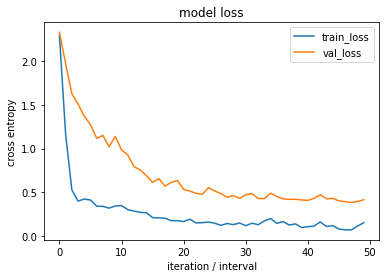

In [256]:
# 上記の学習で描画
learning_curve(50, scnn.cross_entropys, scnn.cross_entropys_val)

In [257]:
# Convolutionなし
X_train = X_train.reshape(-1,784)
X_val = X_val.reshape(-1,784)

affine_1 = FC(784, 
              80, 
              initializer=HeInitializer(784), 
              activator=ReLU(), 
              optimizer=SGD(0.1))

affine_2 = FC(80, 
              40, 
              initializer=HeInitializer(80), 
              activator=ReLU(), 
              optimizer=SGD(0.1))

softmax = FC(40, 
             10, 
             initializer=HeInitializer(40), 
             activator=Softmax(), 
             optimizer=SGD(0.1))

layers = [affine_1, affine_2, softmax]

snn = ScratchCNN1D(layers=layers,
                   batch_size=50, 
                   epoch=50, 
                   interval=2400, 
                   verbose=True)

snn.fit(X_train, y_train, X_val, y_val)

Cross Entropy (train) :
 [2.396765178083582, 0.16612495533208027, 0.10758023236719647, 0.0863736190076123, 0.06528476263943356, 0.06578474571723421, 0.05912953094360847, 0.05442461482110357, 0.04997088069086868, 0.030618064855152363, 0.030766021811835124, 0.024338311237981324, 0.014554113721034235, 0.009221896535256879, 0.005412615271928401, 0.009108333643179273, 0.003871828695919075, 0.0023237473035713514, 0.001909568263472172, 0.020545850853342325, 0.001100677007145911, 0.0015884911128564243, 0.0012119065805073158, 0.0010734117890410938, 0.0010246050349592057, 0.0007632219522708208, 0.0005280756740491306, 0.000536713032783261, 0.0004291529936558909, 0.00040420154850499286, 0.000320020229421419, 0.000316678340069192, 0.00027180927519692815, 0.0002738554660687054, 0.0002384058552570199, 0.0002570005140158368, 0.000247451334869081, 0.00022162445558001918, 0.00024109570977004862, 0.00021966557459170624, 0.00022950038245323306, 0.00022323774926731255, 0.0002194018577200949, 0.000208104994

Accuracy : 0.975


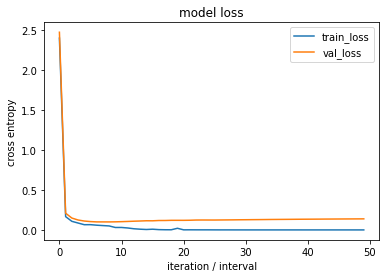

In [263]:
# Accuracy算出
y_pred = snn.predict(X_val)
acc = metrics.accuracy_score(y_val, y_pred)
print('Accuracy : {:.3f}'.format(acc))

# 学習曲線
learning_curve(50, snn.cross_entropys, snn.cross_entropys_val)

== Learning Curves by Layers & Nodes==
< CNN(+) vs CNN(-) >


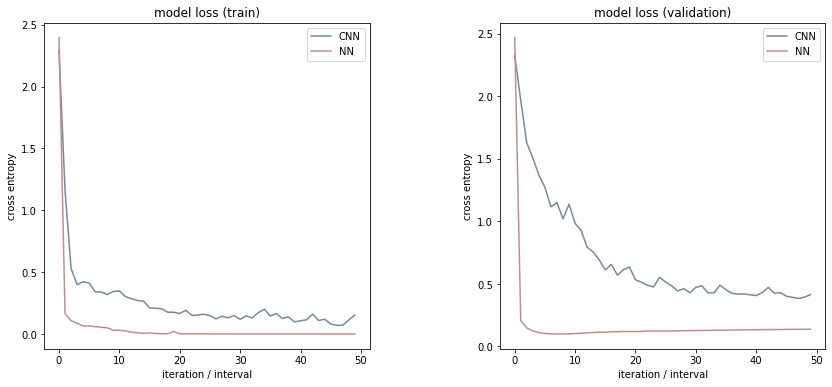

In [262]:
# 手法間でのLearning Curveを比較
print('== Learning Curves by Layers & Nodes==')
print('< CNN(+) vs CNN(-) >')
plt.figure(figsize=(14,6))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# 訓練データ
plt.subplot(1,2,1)
plt.plot(np.arange(50), scnn.cross_entropys, label='CNN', color='lightslategrey')
plt.plot(np.arange(50), snn.cross_entropys, label='NN', color='rosybrown')
plt.title('model loss (train)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

# 検証データ
plt.subplot(1,2,2)
plt.plot(np.arange(50), scnn.cross_entropys_val, label='CNN', color='lightslategrey')
plt.plot(np.arange(50), snn.cross_entropys_val, label='NN', color='rosybrown')
plt.title('model loss (validation)')
plt.xlabel('iteration / interval')
plt.ylabel('cross entropy')
plt.legend()

plt.show()

- CNNでは特にvalidationで学習の進みが遅く、PCの処理時間も長い
- 20epoc程度で定常状態に入ったように見え、それ以降はほとんど学習が進まない
- 色々条件を変えてみたが、通常のNNの精度を上回ることは難しかった